# Judge Hiciano Jupyter Notebook

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [ ]:
!pip install imblearn

In [2]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb



In [104]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('use_inf_as_na', True)
#pd.set_option('precision', 2)

imputer = KNNImputer(n_neighbors=24, weights="uniform")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [105]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")

## Feature Enigneering on Training Data

### Adding new variables to train and fill missing values for certain columns

In [128]:
def feat_eng(df_train, train=False):
    """ Added additional features to dataframe and returns two dataframes.
            customer and non-customer dataframe
    """
    # Get a total number of entries per sessionID
    df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')

    # Get a count of the number of customer 
    df_train['customer_total_orders'] = df_train.groupby('customerID')['customerID'].transform('count')

    # Gets the total duration for a given session
    df_train['total_duration'] = df_train.groupby('sessionID')['duration'].transform('sum')

    # Fills cartStep NaN with -1
    df_train['cartStep'].fillna(0, inplace=True)
    
    df_train['cartStep_total'] = df_train.groupby('sessionID')['cartStep'].transform('sum')

    # Gets the difference between clickTotal and CartTotal
    df_train['missing_items_total'] = df_train['clickTotal']-df_train['cartTotal']
    
    df_train['cartAvg'] = df_train['cartTotal']/df_train['cartCount']
    df_train['clickAvg'] = df_train['clickTotal']/df_train['clickCount']
    df_train['cart_click_diff'] = df_train['cartCount'] - df_train['clickCount']
    
    df_train['clicks_per_session'] = df_train.groupby('sessionID')['clickCount'].transform('max')/df_train['sess_count']
    df_train['cart_item_per_session'] = df_train.groupby('sessionID')['cartCount'].transform('max')/df_train['sess_count']
    
    df_train['cart_vs_purchase'] = df_train['cartTotal']/df_train['purchase']
    df_train['click_vs_purchase'] = df_train['clickTotal']/df_train['purchase']
    
    

    # Converts order and status from y and n to 1 and 0
    if train:
        df_train = df_train.dropna(thresh=17)
        df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
        df_train = df_train.drop(['order'], axis=1)
        
    df_train['status'] = (df_train['status'] !='n').astype(int) #Converts string `order` to int value for training
    
    
    # Drop Columns
    df_train = pd.get_dummies(df_train)
    df_train = df_train.drop("weekday",axis=1)
    
    df_train = df_train.drop(['availability_completely not determinable'], axis=1)
    df_train = df_train.drop(['availability_mainly not determinable'], axis=1)
    df_train = df_train.drop(['availability_mainly not orderable'], axis=1)
    df_train = df_train.drop(['availability_completely not orderable'], axis=1)
    df_train = df_train.drop(['availability_mainly orderable'], axis=1)
    df_train = df_train.drop(['availability_mixed'], axis=1)
    
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    cust = df_train[df_train['customerID'].notnull()]
    #cust = imputer.fit_transform(cust)
    
    
    noncust =df_train
    #noncust = imputer.fit_transform(noncust)
    
    cust.fillna(-100, inplace=True)
    noncust.fillna(-100, inplace=True)
    
    return cust , noncust

In [107]:
df_train_cust, df_train_noncust = feat_eng(df_train, True)
df_test_cust, df_test_noncust = feat_eng(df_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
df_train_noncust.head(20)

,sessionID,hour,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,cartStep_total,missing_items_total,cartAvg,clickAvg,cart_click_diff,clicks_per_session,cart_item_per_session,cart_vs_purchase,click_vs_purchase,ordered,availability_completely orderable
0,1,6,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.990,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,0
1,1,6,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.990,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,1
2,1,6,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.990,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,1
8,3,6,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,59.98,29.990,9.996667,-8,2.200000,0.400000,0.016661,0.049983,1,0
9,3,6,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,69.97,19.990,9.995455,-9,2.200000,0.400000,0.022211,0.061083,1,0
10,3,6,310.967,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,69.97,19.990,9.995455,-9,2.200000,0.400000,0.022211,0.061083,1,1
11,3,6,324.278,11,9.99,29.99,109.95,2,9.99,29.99,39.98,4.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,69.97,19.990,9.995455,-9,2.200000,0.400000,0.022211,0.061083,1,1
12,3,6,341.613,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,69.97,19.990,9.995455,-9,2.200000,0.400000,0.022211,0.061083,1,1
13,4,6,28.871,4,4.99,4.99,19.96,1,4.99,4.99,4.99,0.0,1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,2,-100.0,71.683,1.0,14.97,4.990,4.990000,-3,2.000000,0.500000,-100.000000,-100.000000,0,0
14,4,6,42.812,4,4.99,4.99,19.96,1,4.99,4.99,4.99,1.0,1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,2,-100.0,71.683,1.0,14.97,4.990,4.990000,-3,2.000000,0.500000,-100.000000,-100.000000,0,0


### Customer Dataset

In [108]:
# Shows missing and and missing counts per column
df_train_noncust.info()
df_train_noncust.isnull().sum(axis = 0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426832 entries, 0 to 429012
Data columns (total 35 columns):
sessionID                            426832 non-null int64
hour                                 426832 non-null int64
duration                             426832 non-null float64
clickCount                           426832 non-null int64
clickMin                             426832 non-null float64
clickMax                             426832 non-null float64
clickTotal                           426832 non-null float64
cartCount                            426832 non-null int64
cartMin                              426832 non-null float64
cartMax                              426832 non-null float64
cartTotal                            426832 non-null float64
cartStep                             426832 non-null float64
status                               426832 non-null int64
customerID                           426832 non-null float64
purchase                             426832 n

sessionID                            0
hour                                 0
duration                             0
clickCount                           0
clickMin                             0
clickMax                             0
clickTotal                           0
cartCount                            0
cartMin                              0
cartMax                              0
cartTotal                            0
cartStep                             0
status                               0
customerID                           0
purchase                             0
score                                0
account                              0
payments                             0
age                                  0
salutation                           0
lastOrder                            0
sess_count                           0
customer_total_orders                0
total_duration                       0
cartStep_total                       0
missing_items_total      

### Non-Customer Dataset

#### Drop customer related columns from non-customer dataset

In [109]:
common_columns = ['customer_total_orders','customerID','purchase','score','account','payments','age','salutation','lastOrder']
drop_columns_submission_train = common_columns
drop_columns_submission_test = common_columns
df_train_noncust = df_train_noncust.drop(drop_columns_submission_train,axis=1)
df_test_noncust = df_test_noncust.drop(drop_columns_submission_test,axis=1)

In [110]:
df_train_cust.describe()

,sessionID,hour,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,cartStep_total,missing_items_total,cartAvg,clickAvg,cart_click_diff,clicks_per_session,cart_item_per_session,cart_vs_purchase,click_vs_purchase,ordered,availability_completely orderable
count,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,2.779150e+05,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000,277915.000000
mean,25608.040484,14.638040,1599.297596,25.692111,37.132708,117.289472,976.645427,4.572060,44.384806,80.630904,172.495946,1.228548,0.993635,12184.130921,2461.771045,479.734307,133.318076,15.218016,44.764468,1.734556,79.883975,17.937686,25.386025,4.095252e+04,23.442948,789.826307,57.917658,55.588495,-21.120051,2.317312,0.375362,-2.098547,-0.502096,0.789054,0.590195
std,14466.357211,4.338691,2434.407879,31.067840,110.810044,239.281463,2591.533184,4.673007,129.809566,167.255702,327.031836,1.511996,0.079528,7297.774184,3034.345700,142.234893,111.424775,34.892917,12.837816,0.443903,113.201967,15.693444,84.582574,1.296095e+05,32.002810,2385.636189,136.444963,126.584104,28.761448,3.007871,0.207718,14.982229,13.429678,0.407981,0.491798
min,1.000000,0.000000,0.000000,1.000000,-100.000000,-100.000000,-100.000000,0.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,1.000000,-100.000000,-100.000000,-100.000000,0.000000,-100.000000,1.000000,3.000000,1.000000,1.000000,0.000000e+00,0.000000,-100.000000,-100.000000,-100.000000,-200.000000,0.031250,0.000000,-100.000000,-100.000000,0.000000,0.000000
25%,13029.000000,11.000000,238.358500,6.000000,5.000000,24.990000,131.950000,2.000000,7.000000,19.990000,39.980000,0.000000,1.000000,5793.000000,600.000000,479.000000,41.000000,3.000000,36.000000,1.000000,14.000000,9.000000,9.000000,3.670989e+03,8.000000,57.750000,14.670000,13.798056,-28.000000,0.666667,0.217391,0.018992,0.061983,1.000000,0.000000
50%,26045.000000,15.000000,762.760000,14.000000,9.990000,44.990000,357.820000,3.000000,12.990000,32.990000,83.920000,1.000000,1.000000,12045.000000,1500.000000,519.000000,108.000000,8.000000,45.000000,2.000000,34.000000,14.000000,15.000000,1.257145e+04,16.000000,243.830000,22.490000,21.517000,-10.000000,1.500000,0.333333,0.055409,0.229107,1.000000,1.000000
75%,37990.000000,18.000000,1919.256500,33.000000,19.990000,89.990000,929.320000,6.000000,24.990000,59.990000,180.940000,2.000000,1.000000,18350.000000,4000.000000,554.000000,219.000000,15.000000,53.000000,2.000000,86.000000,22.000000,24.000000,3.732348e+04,28.000000,722.840000,39.990000,38.522159,-3.000000,2.944444,0.500000,0.154950,0.799800,1.000000,1.000000
max,50000.000000,23.000000,21553.323000,200.000000,2799.990000,6999.990000,76239.340000,108.000000,6999.990000,6999.990000,10429.830000,5.000000,1.000000,25038.000000,50000.000000,638.000000,600.000000,868.000000,99.000000,3.000000,738.000000,257.000000,1248.000000,3.221057e+06,649.000000,74899.450000,6999.990000,4211.990000,0.000000,198.000000,1.000000,29.666367,143.950967,1.000000,1.000000


## Adjust Testing Data Set

In [111]:
def match_column(df_train, df_test):
    column_order = []
    for col in df_train.columns: 
        column_order.append(col)
    print(column_order)
    column_order.remove('ordered')
    return df_test[column_order]


In [112]:
df_test_noncust = match_column(df_train_noncust,df_test_noncust)
df_test_noncust.info()
df_train_noncust.info()

['sessionID', 'hour', 'duration', 'clickCount', 'clickMin', 'clickMax', 'clickTotal', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'status', 'sess_count', 'total_duration', 'cartStep_total', 'missing_items_total', 'cartAvg', 'clickAvg', 'cart_click_diff', 'clicks_per_session', 'cart_item_per_session', 'cart_vs_purchase', 'click_vs_purchase', 'ordered', 'availability_completely orderable']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45068 entries, 0 to 45067
Data columns (total 25 columns):
sessionID                            45068 non-null int64
hour                                 45068 non-null int64
duration                             45068 non-null float64
clickCount                           45068 non-null int64
clickMin                             45068 non-null float64
clickMax                             45068 non-null float64
clickTotal                           45068 non-null float64
cartCount                            45068 non-null int64
cartMin     

In [113]:
df_test_cust = match_column(df_train_cust, df_test_cust)
df_test_cust.info()
df_train_cust.info()
df_train_cust.head()

['sessionID', 'hour', 'duration', 'clickCount', 'clickMin', 'clickMax', 'clickTotal', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'status', 'customerID', 'purchase', 'score', 'account', 'payments', 'age', 'salutation', 'lastOrder', 'sess_count', 'customer_total_orders', 'total_duration', 'cartStep_total', 'missing_items_total', 'cartAvg', 'clickAvg', 'cart_click_diff', 'clicks_per_session', 'cart_item_per_session', 'cart_vs_purchase', 'click_vs_purchase', 'ordered', 'availability_completely orderable']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27804 entries, 0 to 45039
Data columns (total 34 columns):
sessionID                            27804 non-null int64
hour                                 27804 non-null int64
duration                             27804 non-null float64
clickCount                           27804 non-null int64
clickMin                             27804 non-null float64
clickMax                             27804 non-null float64
clickTotal   

,sessionID,hour,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,cartStep_total,missing_items_total,cartAvg,clickAvg,cart_click_diff,clicks_per_session,cart_item_per_session,cart_vs_purchase,click_vs_purchase,ordered,availability_completely orderable
0,1,6,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.99,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,0
1,1,6,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.99,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,1
2,1,6,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,2.0,0.00,59.99,59.990000,0,0.333333,0.333333,0.099983,0.099983,1,1
8,3,6,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,59.98,29.99,9.996667,-8,2.200000,0.400000,0.016661,0.049983,1,0
9,3,6,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,1,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,4.0,69.97,19.99,9.995455,-9,2.200000,0.400000,0.022211,0.061083,1,0


## Create training and testing datasets

In [114]:
df_train_noncust_f = df_train_noncust.drop(['sessionID'],axis=1)
df_train_cust_f = df_train_cust.drop(['sessionID'],axis=1)
df_test_noncust_f = df_test_noncust.drop(['sessionID'],axis=1)
df_test_cust_f = df_test_cust.drop(['sessionID'],axis=1)

# df_train_noncust_f = df_train_noncust_f.drop(['hour'],axis=1)
# df_train_cust_f = df_train_cust_f.drop(['hour'],axis=1)
# df_test_noncust_f = df_test_noncust_f.drop(['hour'],axis=1)
# df_test_cust_f = df_test_cust_f.drop(['hour'],axis=1)

In [115]:
df_train_cust_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277915 entries, 0 to 429012
Data columns (total 34 columns):
hour                                 277915 non-null int64
duration                             277915 non-null float64
clickCount                           277915 non-null int64
clickMin                             277915 non-null float64
clickMax                             277915 non-null float64
clickTotal                           277915 non-null float64
cartCount                            277915 non-null int64
cartMin                              277915 non-null float64
cartMax                              277915 non-null float64
cartTotal                            277915 non-null float64
cartStep                             277915 non-null float64
status                               277915 non-null int64
customerID                           277915 non-null float64
purchase                             277915 non-null float64
score                                277915

sns.pairplot(df_train_noncust_f, hue='ordered')

sns.pairplot(df_test_noncust_f)

In [116]:
print(df_train_noncust_f[df_train_noncust_f['ordered']==0].count()/len(df_train_noncust_f))
print(df_train_cust_f[df_train_cust_f['ordered']==0].count()/len(df_train_cust_f))

hour                                 0.321958
duration                             0.321958
clickCount                           0.321958
clickMin                             0.321958
clickMax                             0.321958
clickTotal                           0.321958
cartCount                            0.321958
cartMin                              0.321958
cartMax                              0.321958
cartTotal                            0.321958
cartStep                             0.321958
status                               0.321958
sess_count                           0.321958
total_duration                       0.321958
cartStep_total                       0.321958
missing_items_total                  0.321958
cartAvg                              0.321958
clickAvg                             0.321958
cart_click_diff                      0.321958
clicks_per_session                   0.321958
cart_item_per_session                0.321958
cart_vs_purchase                  

In [117]:
X, y = df_train_noncust_f.drop(['ordered'],axis=1), df_train_noncust_f.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)

In [121]:
X, y = df_train_cust_f.drop(['ordered'],axis=1), df_train_cust_f.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)

In [ ]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

models.append(("RF",RandomForestClassifier()))
models.append(("EF",ExtraTreesClassifier()))

#models.append(("Ada",AdaBoostClassifier()))
#models.append(("XGB",xgb.XGBClassifier()))
models.append(("Bagging",BaggingClassifier()))
#models.append(("Gradient",GradientBoostingClassifier()))
#models.append(("Hist",HistGradientBoostingClassifier,GradientBoostingClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=7, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 19,24,26, 32,48]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

In [ ]:
max_depths = np.linspace(10, 50, 40, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest

base_estimator=[RandomForestClassifier(),None]
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 40)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(start = 10, stop = 50, num = 40)]
# Maximum number of levels in tree


bootstrap = [True,False]
bootstrap_features = [True,False]
oob_score=[True,False]
# Create the random grid
warm_start = [True, False]
random_grid = {'base_estimator':base_estimator,
    'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap_features': bootstrap_features,
               'bootstrap': bootstrap,
               'oob_score': oob_score,
              'warm_start':warm_start}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = BaggingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 25,
                               cv = 3,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None, 8]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2, 3,4,5,6,7,8,9, 10,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2, 3,4,5,6,7,8,9, 10,]
# Method of selecting samples for training each tree
bootstrap = [True,False]
oob_score=[True,False]
# Create the random grid
class_weights = [1,2,3,4,5]
warm_start = [True, False]
max_leaf_nodes = [1,2,10,20,50,100,None]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score,
              'max_leaf_nodes':max_leaf_nodes,
              'warm_start':warm_start}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = BalancedRandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 25,
                               cv = 7,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

In [ ]:
rc_random.best_params_

In [35]:
#Non-Customer Model
clf1 = BaggingClassifier()

In [123]:
#Non-Customer Model
clf2 = RandomForestClassifier(
                              oob_score=True,
                              max_depth = None,
                              n_estimators=37,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=9,
                              min_samples_split=2,
    max_leaf_nodes=None,
    warm_start=True,
                              class_weight={0:3,1:1})

clf3 = BalancedRandomForestClassifier(
                              oob_score=True,
                              max_depth = None,
                              n_estimators=37,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=9,
                              min_samples_split=2,
    warm_start=True,
    max_leaf_nodes=None)


clf3 = BalancedRandomForestClassifier(
                              oob_score=True,
                              max_depth = None,
                              n_estimators=37,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=9,
                              min_samples_split=2,
    warm_start=True,
    max_leaf_nodes=None)

In [53]:
#Customer Model
# clf2 = ExtraTreesClassifier(
#                               oob_score=False,
#                               max_depth = 53,
#                               n_estimators=31,
#                               random_state=0,
#                               max_features='auto',
#                               bootstrap=False,
#                               min_samples_leaf=2,
#                               min_samples_split=3)

multi_target_forest = MultiOutputClassifier(clf2, n_jobs=-1)

clf3.fit(X_train, y_train)
features = X_train.columns.values
importances = clf3.feature_importances_
indices = np.argsort(importances)
pprint(clf3.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()
clf3.score(X_test, y_test)

In [55]:
clf1.fit(X_train, y_train)
# features = X_train.columns.values
# importances = clf1.feature_importances_
# indices = np.argsort(importances)
# pprint(clf1.get_params())
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
# plt.show()
clf1.score(X_test, y_test)

0.9952683374413039

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 3, 1: 1},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 37,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': True}


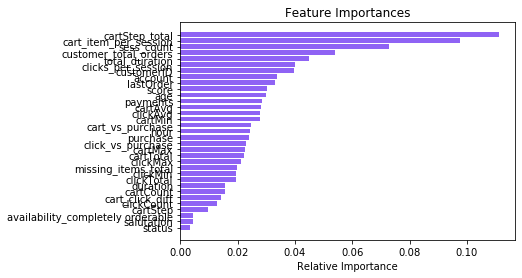

0.978860442941187

In [124]:
clf2.fit(X_train, y_train)
features = X_train.columns.values
importances = clf2.feature_importances_
indices = np.argsort(importances)
pprint(clf2.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()
clf2.score(X_test, y_test)

In [57]:
results_cust1 = clf1.predict(df_test_cust_f)
results_cust2 = clf2.predict(df_test_cust_f)
results_cust3 = clf3.predict(df_test_cust_f)

df_results1 = pd.DataFrame({"sessionID":df_test_cust.sessionID, "order_int":results_cust1})
df_results2 = pd.DataFrame({"sessionID":df_test_cust.sessionID, "order_int":results_cust2})
df_results3 = pd.DataFrame({"sessionID":df_test_cust.sessionID, "order_int":results_cust3})

df_results1.rename(columns={'order_int': 'order_int1'}, inplace=True)
df_results1['order_int2'] = df_results2['order_int']
df_results1['order_int3'] = df_results2['order_int']
df_results1['order_int_f'] = df_results1['order_int1']+df_results1['order_int2']+df_results1['order_int3']
df_results1.loc[df_results1['order_int_f']>=2,'order_int'] = 1
df_results1.loc[df_results1['order_int_f']<2,'order_int'] = 0
df_results1.drop(['order_int1','order_int2','order_int3','order_int_f'], axis=1, inplace=True)

df_results_cust = df_results1

In [39]:
results_non_cust1 = clf1.predict(df_test_noncust_f)
results_non_cust2 = clf2.predict(df_test_noncust_f)
results_non_cust3 = clf3.predict(df_test_noncust_f)

df_results1 = pd.DataFrame({"sessionID":df_test_noncust.sessionID, "order_int":results_non_cust1})
df_results2 = pd.DataFrame({"sessionID":df_test_noncust.sessionID, "order_int":results_non_cust2})
df_results3 = pd.DataFrame({"sessionID":df_test_noncust.sessionID, "order_int":results_non_cust3})

df_results1.rename(columns={'order_int': 'order_int1'}, inplace=True)
df_results1['order_int2'] = df_results2['order_int']
df_results1['order_int3'] = df_results2['order_int']
df_results1['order_int_f'] = df_results1['order_int1']+df_results1['order_int2']+df_results1['order_int3']
df_results1.loc[df_results1['order_int_f']>=2,'order_int'] = 1
df_results1.loc[df_results1['order_int_f']<2,'order_int'] = 0
df_results1.drop(['order_int1','order_int2','order_int3','order_int_f'], axis=1, inplace=True)

df_results = df_results1

In [ ]:
df_results1.info(100)

In [125]:
results_cust = clf2.predict(df_test_cust_f)

In [120]:
results_non_cust = clf2.predict(df_test_noncust_f)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [126]:
df_results = pd.DataFrame({"sessionID":df_test_noncust.sessionID, "order_int":results_non_cust2})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )

df_results_cust = pd.DataFrame({"sessionID":df_test_cust.sessionID, "order_int":results_cust})
df_results_cust.sort_values(by=['order_int'], ascending=False)
df_dist_cust  = df_results_cust.drop_duplicates(subset = "sessionID", )

df_dist = df_dist.append(df_dist_cust, ignore_index=True, sort=False)
df_final = df_dist.sort_values(by=['sessionID'])

df_final.sort_values(by=['order_int'], ascending=False)
df_final  = df_final.drop_duplicates(subset = "sessionID", )

df_final.loc[df_final['order_int']==1,'order'] = 'y'
df_final['order'].fillna('n', inplace=True)
df_final = df_final.drop('order_int',axis=1)

df_final = df_final.sort_values(by=['sessionID'], ascending=True)
print(len(df_final))
df_final.head()

5111


,sessionID,order
0,50001,n
1,50002,y
2,50003,y
3,50004,n
4,50005,n


In [127]:
df_final.to_csv("../data/results.csv", index=False)